# Suzuki s–q sampler — validation notebook

This notebook constructs normalized CDFs for the Suzuki et al. (2016) broken power-law in log q and a single power-law in log s. It demonstrates inverse-CDF sampling from uniform draws, and validates with histograms across multiple `(s, q)` ranges.

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Never use seaborn; one chart per figure by design.


## Parameters and analytic helpers

In [2]:

# Suzuki et al. (2016) parameters (All-sample; q_break fixed)
SUZUKI_Q_BREAK = 1.7e-4
SUZUKI_N = -0.92     # slope for q >= q_break (log-space exponent of density)
SUZUKI_P = 0.44      # slope for q < q_break
SUZUKI_M = 0.50      # slope in log s (dN/dlog s ∝ s^M)

# Default bounds used in the script
LOG10_Q_MIN = np.log10(2.6e-5)
LOG10_Q_MAX = np.log10(3.0e-2)
LOG10_S_MIN = np.log10(0.1)
LOG10_S_MAX = np.log10(10.0)

LOG10_Q_BREAK = np.log10(SUZUKI_Q_BREAK)

def _segment_integral(slope, lower, upper, pivot):
    """∫ 10^{slope (x - pivot)} dx from x=lower..upper in log10-space."""
    if upper <= lower:
        return 0.0
    if abs(slope) < 1e-12:
        return upper - lower
    start = 10.0 ** (slope * (lower - pivot))
    stop  = 10.0 ** (slope * (upper - pivot))
    return (stop - start) / (slope * np.log(10.0))

def _sample_segment(u, slope, lower, upper, pivot):
    """Inverse CDF for a single power-law segment in log10-space."""
    if abs(slope) < 1e-12:
        return lower + (upper - lower) * u
    start = 10.0 ** (slope * (lower - pivot))
    stop  = 10.0 ** (slope * (upper - pivot))
    vals = start + u * (stop - start)
    return pivot + np.log10(vals) / slope

def sample_log_break_powerlaw(size, *, log_min, log_max, log_break, slope_low, slope_high, rng):
    """Sample x = log10 q from a broken power-law with a single break."""
    if log_min >= log_max:
        raise ValueError("log_min must be < log_max")
    low_hi = min(log_break, log_max)
    high_lo = max(log_break, log_min)
    w_low  = _segment_integral(slope_low,  log_min, low_hi,  log_break)
    w_high = _segment_integral(slope_high, high_lo, log_max, log_break)
    total = w_low + w_high
    if total <= 0:
        raise ValueError("Degenerate interval; total weight zero.")
    u = rng.random(size)
    x = np.empty(size, float)
    if w_low > 0 and w_high > 0:
        split = max(min(w_low/total, 1-1e-12), 1e-12)
        mask = u < split
        x[mask]  = _sample_segment(u[mask]/split, slope_low,  log_min, low_hi,  log_break)
        x[~mask] = _sample_segment((u[~mask]-split)/(1-split), slope_high, high_lo, log_max, log_break)
    elif w_low > 0:
        x[:] = _sample_segment(u, slope_low,  log_min, low_hi,  log_break)
    else:
        x[:] = _sample_segment(u, slope_high, high_lo, log_max, log_break)
    return x

def sample_log_powerlaw(size, *, log_min, log_max, slope, rng):
    u = rng.random(size)
    return _sample_segment(u, slope, log_min, log_max, pivot=0.0)

def draw_s_and_q(size, *, 
                 log10_q_min=LOG10_Q_MIN, log10_q_max=LOG10_Q_MAX,
                 log10_s_min=LOG10_S_MIN, log10_s_max=LOG10_S_MAX,
                 rng=None):
    rng = np.random.default_rng() if rng is None else rng
    logq = sample_log_break_powerlaw(size,
                                     log_min=log10_q_min, log_max=log10_q_max,
                                     log_break=LOG10_Q_BREAK,
                                     slope_low=SUZUKI_P, slope_high=SUZUKI_N,
                                     rng=rng)
    logs = sample_log_powerlaw(size,
                               log_min=log10_s_min, log_max=log10_s_max,
                               slope=SUZUKI_M, rng=rng)
    return 10**logq, 10**logs


## Construct and visualize normalized CDFs

In [3]:

def cdf_single_segment(x, slope, lower, upper, pivot):
    """Normalized CDF for a single segment over [lower, upper] in log10-space."""
    # x, lower, upper are in log10 space
    if slope == 0:
        return (np.clip(x, lower, upper) - lower) / (upper - lower)
    # F(x) = (10^{k(x-l0)} - 1) / (10^{k(upper-l0)} - 1) with pivot=l0 for stability
    num   = 10**(slope * (np.clip(x, lower, upper) - pivot)) - 10**(slope * (lower - pivot))
    denom = 10**(slope * (upper - pivot)) - 10**(slope * (lower - pivot))
    return num / denom

def cdf_broken(x, log_min, log_max, log_break, slope_low, slope_high):
    # Piecewise normalized CDF across [log_min, log_max]
    low_hi  = min(log_break, log_max)
    high_lo = max(log_break, log_min)
    w_low  = _segment_integral(slope_low,  log_min, low_hi,  log_break)
    w_high = _segment_integral(slope_high, high_lo, log_max, log_break)
    total = w_low + w_high
    p_low = w_low / total
    x = np.asarray(x)
    F = np.zeros_like(x, dtype=float)
    # Lower segment portion
    mask_low  = (x < log_break)
    x_low     = np.clip(x[mask_low],  log_min, low_hi)
    F_low     = cdf_single_segment(x_low, slope_low, log_min, low_hi, log_break)
    F[mask_low] = p_low * F_low
    # Upper segment portion
    mask_high = ~mask_low
    x_high = np.clip(x[mask_high], high_lo, log_max)
    F_high = cdf_single_segment(x_high, slope_high, high_lo, log_max, log_break)
    F[mask_high] = p_low + (1 - p_low) * F_high
    return F


## Map uniform draws to target distributions; histogram checks

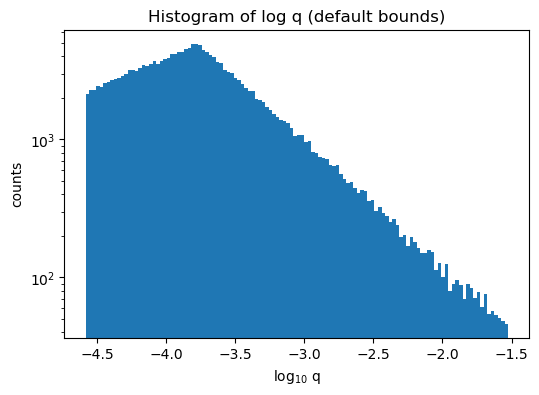

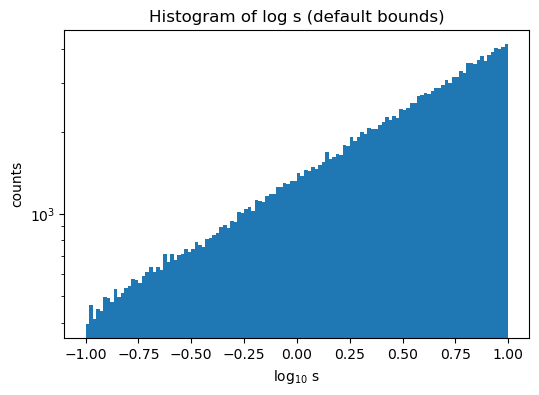

In [8]:

rng = np.random.default_rng(12345)
N = 200_000

q, s = draw_s_and_q(N, rng=rng)

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(np.log10(q), bins=120)
ax.set_xlabel(r'log$_{10}$ q'); ax.set_ylabel('counts')
ax.set_title('Histogram of log q (default bounds)')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(np.log10(s), bins=120)
ax.set_xlabel(r'log$_{10}$ s'); ax.set_ylabel('counts')
ax.set_title('Histogram of log s (default bounds)')
ax.set_yscale('log')
plt.show()


## Empirical vs analytic CDFs (q)

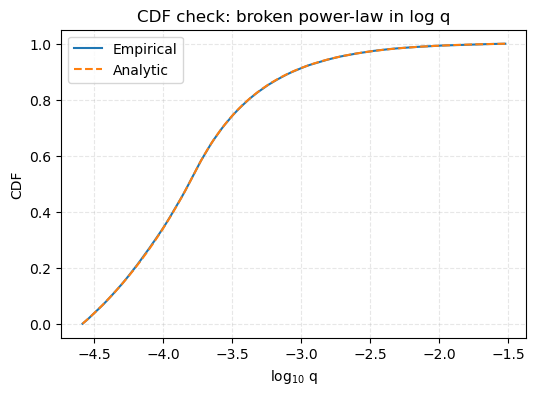

In [5]:

# Compare empirical CDF of log q to analytic broken-power-law CDF
logq = np.log10(q)
xs = np.linspace(LOG10_Q_MIN, LOG10_Q_MAX, 600)
F_emp = np.searchsorted(np.sort(logq), xs, side='right') / logq.size
F_th  = cdf_broken(xs, LOG10_Q_MIN, LOG10_Q_MAX, LOG10_Q_BREAK, SUZUKI_P, SUZUKI_N)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(xs, F_emp, label='Empirical')
ax.plot(xs, F_th,  label='Analytic', linestyle='--')
ax.set_xlabel(r'log$_{10}$ q'); ax.set_ylabel('CDF')
ax.set_title('CDF check: broken power-law in log q')
ax.legend(); ax.grid(True, which='both', linestyle='--', alpha=0.3)
plt.show()


## Alternate ranges (stress tests)

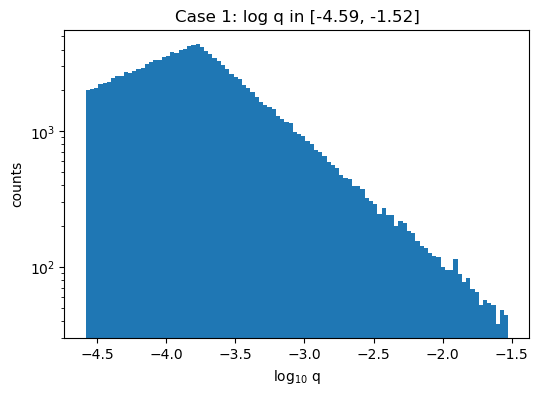

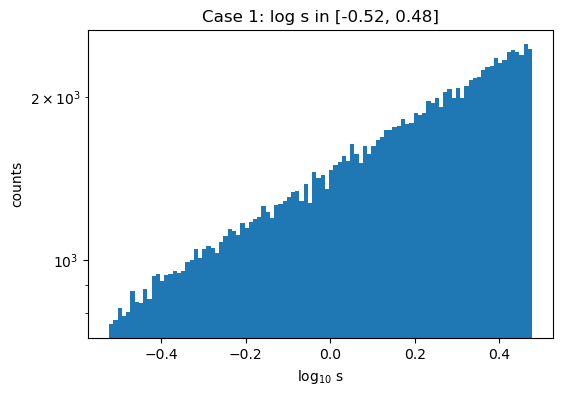

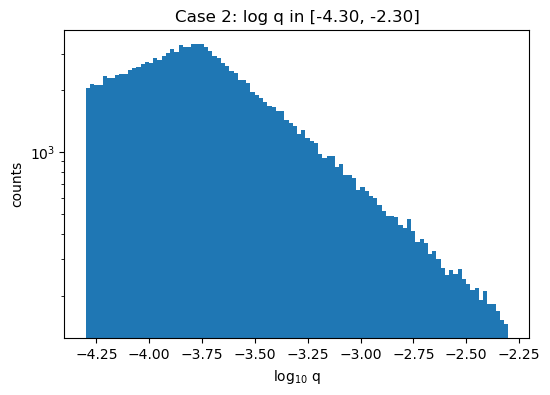

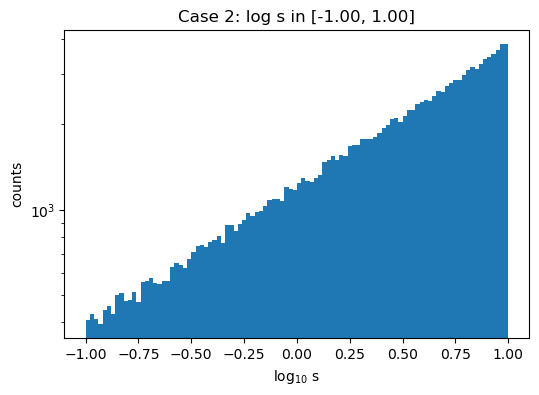

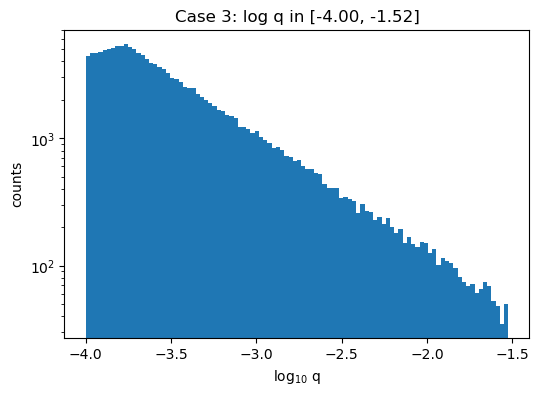

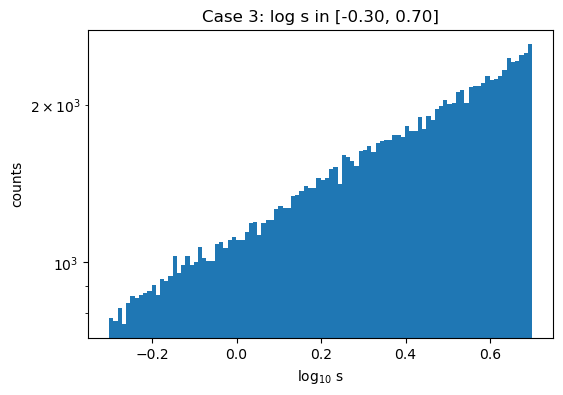

In [9]:

tests = [
    dict(qmin=LOG10_Q_MIN, qmax=LOG10_Q_MAX, smin=np.log10(0.3), smax=np.log10(3.0)),
    dict(qmin=np.log10(5e-5), qmax=np.log10(5e-3), smin=LOG10_S_MIN, smax=LOG10_S_MAX),
    dict(qmin=np.log10(1e-4), qmax=np.log10(3e-2), smin=np.log10(0.5), smax=np.log10(5.0)),
]

for i, T in enumerate(tests, 1):
    qi, si = draw_s_and_q(150_000, 
                          log10_q_min=T['qmin'], log10_q_max=T['qmax'],
                          log10_s_min=T['smin'], log10_s_max=T['smax'],
                          rng=rng)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(np.log10(qi), bins=100)
    ax.set_xlabel(r'log$_{10}$ q'); ax.set_ylabel('counts')
    ax.set_title(f'Case {i}: log q in [{T["qmin"]:.2f}, {T["qmax"]:.2f}]')
    ax.set_yscale('log')
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(np.log10(si), bins=100)
    ax.set_xlabel(r'log$_{10}$ s'); ax.set_ylabel('counts')
    ax.set_title(f'Case {i}: log s in [{T["smin"]:.2f}, {T["smax"]:.2f}]')
    ax.set_yscale('log')
    plt.show()
